# 階層ベイズモデル 負の二項分布

In [78]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
from graphviz import Digraph
from patsy import dmatrix

In [2]:
filepath = "../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df = df.dropna()

/tmp/ipykernel_20494/3407249749.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()


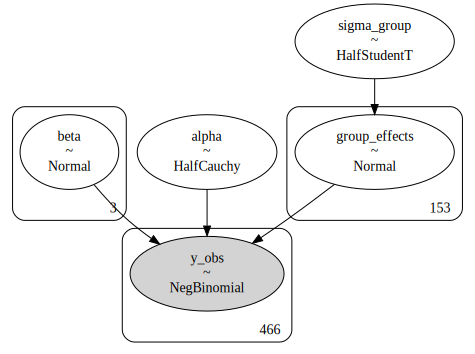

In [89]:
formula = 'dummy_after_bridge_opened + log_income'
response_var = 'population'
group_var = 'island_id'

X = dmatrix(formula, data=df, return_type='dataframe')
y = df[response_var]
groups = pd.Categorical(df[group_var])
group_codes = groups.codes
n_groups = len(groups.categories)

# モデルの定義
with pm.Model() as model:
    # 固定効果の事前分布
    beta = pm.Normal('beta', mu=0, sigma=100, shape=X.shape[1])
    
    # グループレベルの効果の事前分布（階層構造）
    sigma_group = pm.HalfStudentT('sigma_group', nu=4, sigma=100)
    group_effects = pm.Normal('group_effects', mu=0, sigma=sigma_group, shape=n_groups)
    
    # 過分散パラメータ（負の二項分布用）
    alpha = pm.HalfCauchy('alpha', beta=5)
    
    # 線形予測子
    mu = pm.math.dot(X, beta) + group_effects[group_codes]
    theta = pm.math.exp(mu)
    
    # 尤度関数（負の二項分布）
    y_obs = pm.NegativeBinomial('y_obs', mu=theta, alpha=alpha, observed=y)

# モデルの視覚化
graph = pm.model_to_graphviz(model)
graph.render(filename='../../visualization/graphviz/hbm_negative_binomial_5years', format='png', cleanup=True)
graph

In [97]:
with model:
    idata = pm.sample(
        draws=5000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [99]:
az.to_netcdf(idata, '../../mcmc_results/hbm_negative_binomial_5years.nc')

'../../mcmc_results/hbm_negative_binomial_5years.nc'

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],6.926,0.340,6.303,7.582,0.015,0.011,487.0,1564.0,1.01
beta[1],-0.073,0.079,-0.225,0.074,0.002,0.001,1958.0,3795.0,1.00
beta[2],-0.094,0.017,-0.126,-0.062,0.000,0.000,2104.0,4223.0,1.00
group_effects[0],4.241,0.201,3.863,4.617,0.016,0.011,165.0,299.0,1.03
group_effects[1],2.310,0.190,1.944,2.655,0.016,0.011,144.0,265.0,1.03
...,...,...,...,...,...,...,...,...,...
group_effects[150],0.803,0.264,0.298,1.292,0.015,0.011,296.0,1145.0,1.02
group_effects[151],-1.535,0.219,-1.956,-1.136,0.016,0.011,194.0,367.0,1.02
group_effects[152],-0.082,0.207,-0.475,0.301,0.016,0.011,165.0,317.0,1.03
sigma_group,2.192,0.132,1.947,2.440,0.001,0.001,10721.0,12333.0,1.00


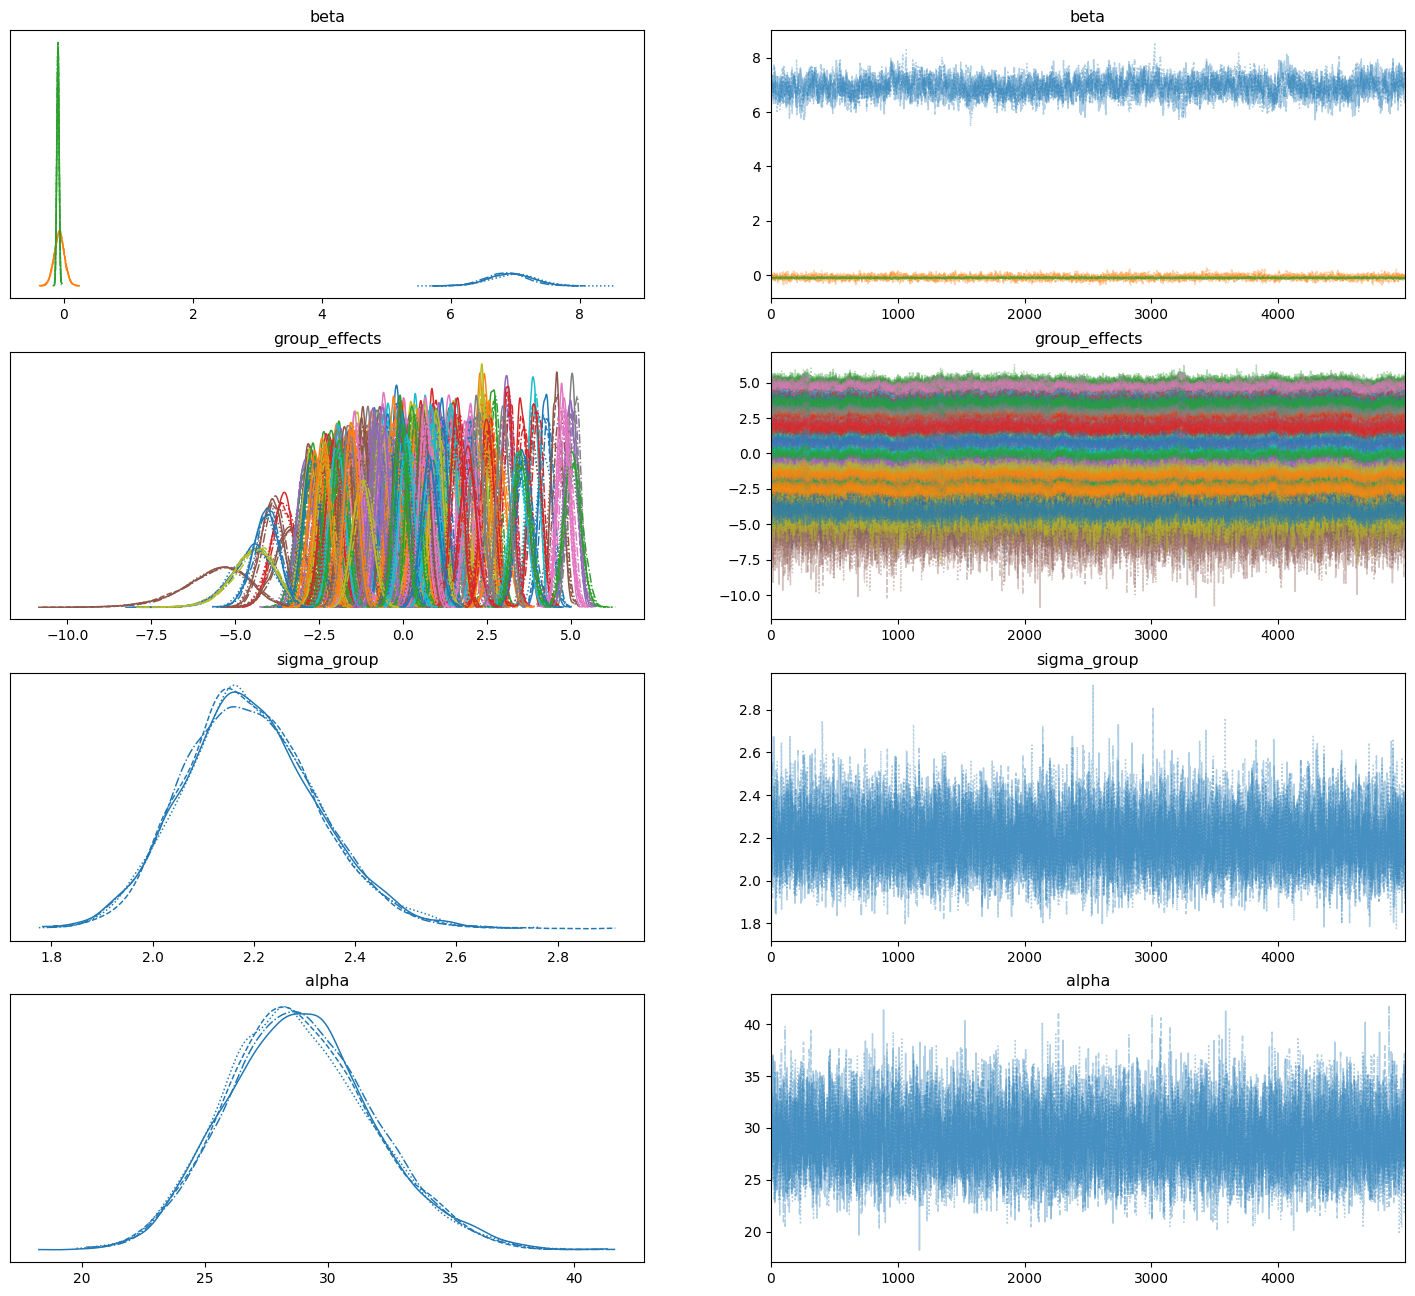

In [100]:
az.plot_trace(idata, figsize=(18, 16))  # サイズを調整
az.summary(idata)

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'sigma_group'}>,
        <Axes: title={'center': 'alpha'}>, <Axes: >]], dtype=object)

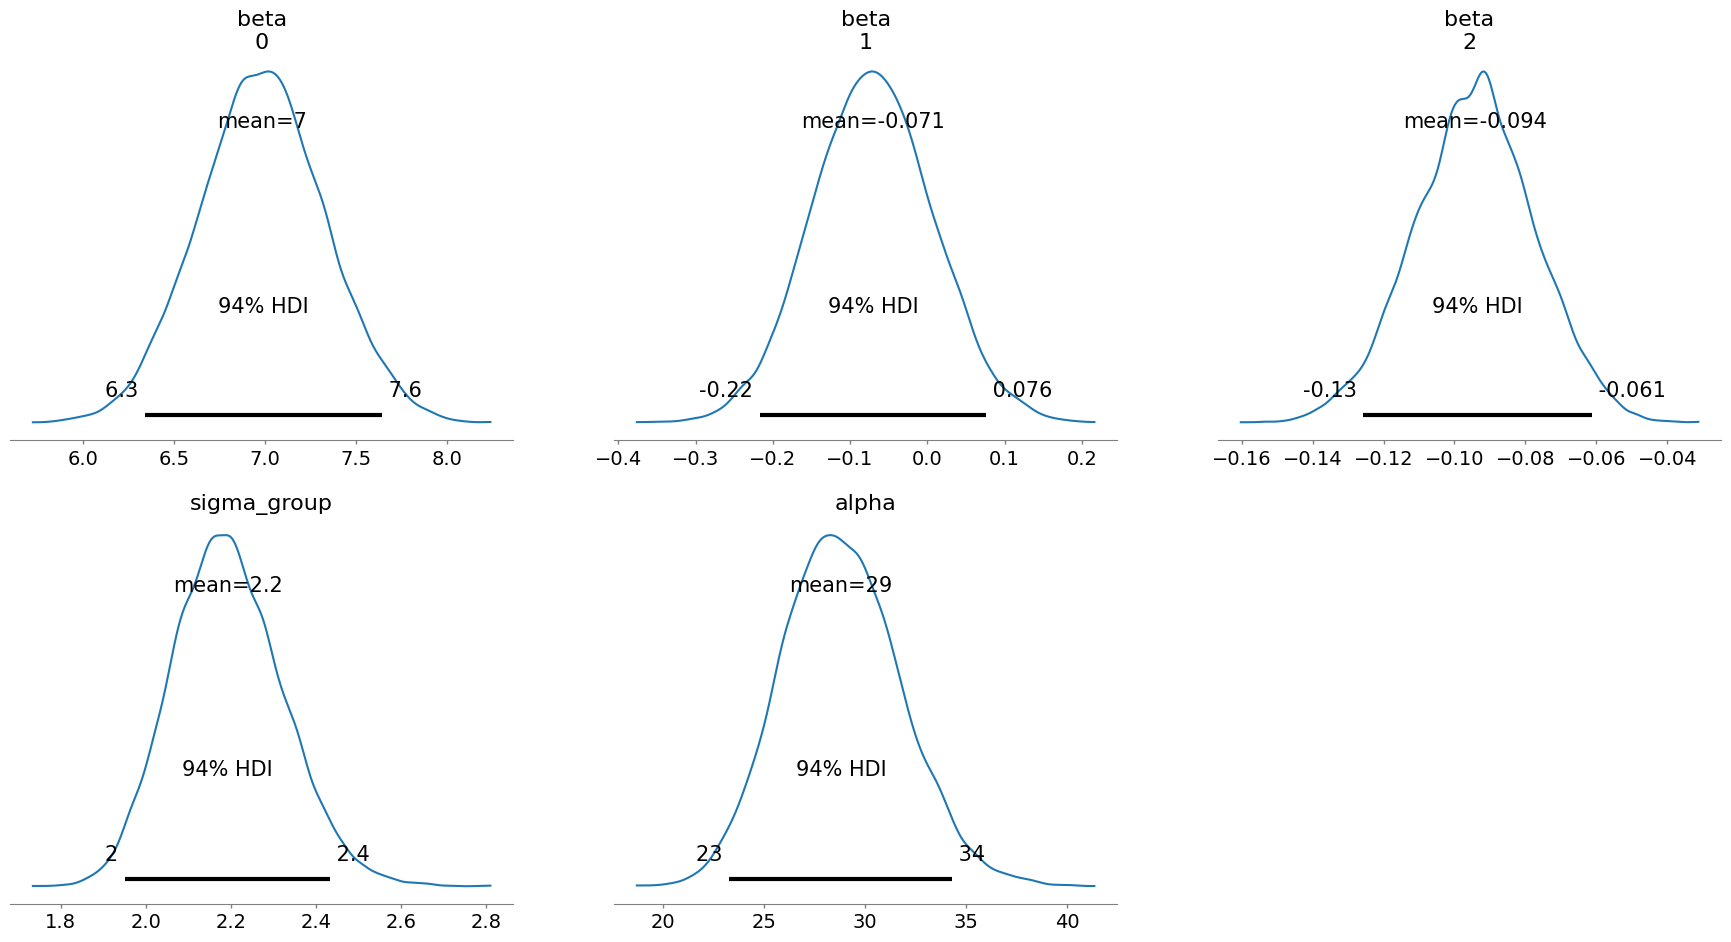

In [95]:
# 結果の要約
az.summary(idata, var_names=['beta', 'sigma_group', 'alpha'])

# 事後分布のプロット
az.plot_posterior(idata, var_names=['beta', 'sigma_group', 'alpha'])

# 橋ダミーのパラメータが0以上である確率

In [111]:
beta_bridge_samples = idata.posterior.beta[1]

prob_beta_bridge_positive = np.mean(beta_bridge_samples >= 0)

print(f"P(beta_1 >= 0) = {prob_beta_bridge_positive:.4f}")

P(beta_1 >= 0) = 0.3937
